In [42]:
import numpy as np
import pandas as pd
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [43]:
df = pd.read_pickle("data/df_train.pkl")

df_train, df_val = train_test_split(df, test_size= 0.1, random_state=42)

In [77]:
X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

In [ ]:
df_train.head(3)

,id,industry,business_description_embedding
31138,34170,Financial Services,"[0.019633012,0.009427597,0.006240986,0.0177257..."
15120,16504,Technology Hardware & Equipment,"[0.026561439,-0.049749356,-0.006847293,-0.0088..."
23693,25893,Consumer Durables & Apparel,"[0.0115894,-0.035240766,-0.029952582,0.0226988..."


# Transforming Data (Label Encoding)

### Tasks:
- Use the scikit-learn label encoder to encode the industry names
- Check if all classes contained in the validation set are also in the training set

#

In [ ]:
label_encoder = LabelEncoder().fit(y=df_train["industry"].values.ravel())
print(label_encoder.classes_)


['Automobiles & Components' 'Banks' 'Capital Goods'
 'Commercial & Professional Services'
 'Consumer Discretionary Distribution & Retail'
 'Consumer Durables & Apparel' 'Consumer Services'
 'Consumer Staples Distribution & Retail' 'Energy'
 'Equity Real Estate Investment Trusts (REITs)' 'Financial Services'
 'Food, Beverage & Tobacco' 'Health Care Equipment & Services'
 'Household & Personal Products' 'Insurance' 'Materials'
 'Media & Entertainment' 'Pharmaceuticals, Biotechnology & Life Sciences'
 'Real Estate Management & Development'
 'Semiconductors & Semiconductor Equipment' 'Software & Services'
 'Technology Hardware & Equipment' 'Telecommunication Services'
 'Transportation' 'Utilities']


In [ ]:
train_classes = set(df_train['industry'].sort_values())
print("Training classes:", train_classes)
val_classes = set(df_val['industry'].sort_values())
print("Validation classes:", val_classes)
if val_classes == train_classes:
    print("validation and training set contain the exact same classes")
elif val_classes.issubset(train_classes):
    print("Validation set is a subset of training set, but training set has additional classes")
else: print("Attention: validation set contains classes that are not in the training set")

Training classes: {'Household & Personal Products', 'Software & Services', 'Health Care Equipment & Services', 'Semiconductors & Semiconductor Equipment', 'Financial Services', 'Capital Goods', 'Consumer Services', 'Media & Entertainment', 'Insurance', 'Food, Beverage & Tobacco', 'Utilities', 'Energy', 'Telecommunication Services', 'Real Estate Management & Development', 'Transportation', 'Materials', 'Equity Real Estate Investment Trusts (REITs)', 'Technology Hardware & Equipment', 'Consumer Staples Distribution & Retail', 'Banks', 'Automobiles & Components', 'Consumer Discretionary Distribution & Retail', 'Consumer Durables & Apparel', 'Pharmaceuticals, Biotechnology & Life Sciences', 'Commercial & Professional Services'}
Validation classes: {'Household & Personal Products', 'Software & Services', 'Health Care Equipment & Services', 'Semiconductors & Semiconductor Equipment', 'Financial Services', 'Capital Goods', 'Consumer Services', 'Media & Entertainment', 'Insurance', 'Food, Beve

In [ ]:
y_train = label_encoder.transform(df_train['industry'])
y_val = label_encoder.transform(df_val['industry']) 


# Visualize the data

### Tasks:
- Are certain classes over- or under represented? Either produce a table or a plot to show this.
- Inspect whether there is signal in the business description embeddings:
    - Perform a PCA to project data into 2 dimensions
    - Plot projected data in Scatterplot and color based on classes
    - Provide a description of what you see and judge whether there is signal in the data that allows industry classification

Important: Ensure that your plots have proper axis descriptions and titles. Style the plots so that differences in class distributions are visible (e.g. scatter size, transparency, color, etc.)

### Class distribution

/var/folders/1m/fhfc5x3d4j72lq0b494s5nkw0000gn/T/ipykernel_11915/579003968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


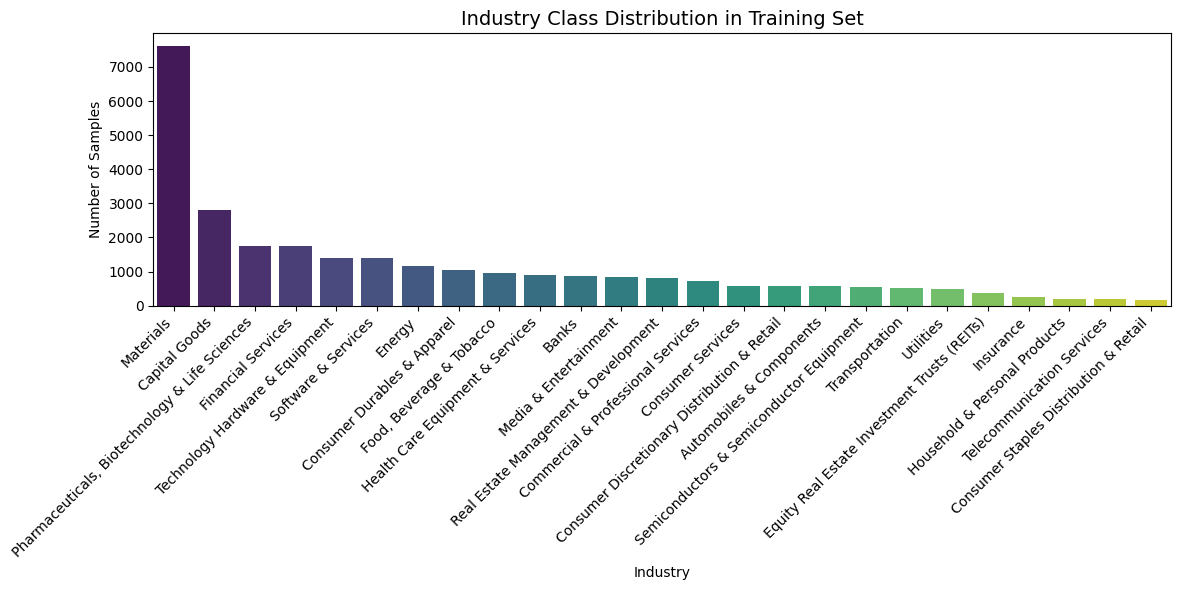

In [47]:
plt.figure(figsize=(12,6))
sns.barplot(
    x=df_train['industry'].value_counts().index,
    y=df_train['industry'].value_counts().values,
    palette='viridis'
)
plt.title("Industry Class Distribution in Training Set", fontsize=14)
plt.xlabel("Industry")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
print("Class Distribution with Percentages:\n")
print(
    df_train['industry']
    .value_counts(normalize=False)
    .to_frame(name='count')
    .assign(percentage=lambda df: (df['count'] / df['count'].sum() * 100).round(2))
    .reset_index()
    .rename(columns={'index': 'industry'})
)

Class Distribution with Percentages:

                                          industry  count  percentage
0                                        Materials   7604       26.65
1                                    Capital Goods   2805        9.83
2   Pharmaceuticals, Biotechnology & Life Sciences   1742        6.10
3                               Financial Services   1740        6.10
4                  Technology Hardware & Equipment   1390        4.87
5                              Software & Services   1384        4.85
6                                           Energy   1174        4.11
7                      Consumer Durables & Apparel   1037        3.63
8                         Food, Beverage & Tobacco    956        3.35
9                 Health Care Equipment & Services    911        3.19
10                                           Banks    874        3.06
11                           Media & Entertainment    827        2.90
12            Real Estate Management & Development  

## <span style='color: green;'>Our Findings</span>
The classes are not well balanced. Instead, the "Materials" class is highly overrepresented, and the "Capital Goods", "Pharmaceuticals, Biotechnology & Life Sciences" and "Financial Services" classes are slightly overrepresented. Underrepresented classes are (from slighlty to most underrepresented) "Insureance", "Household & Personal Products", "Telecommunication Services" and "Consumer Staples Distribution & Retail".


### PCA - Dimensionality reduction and visualization

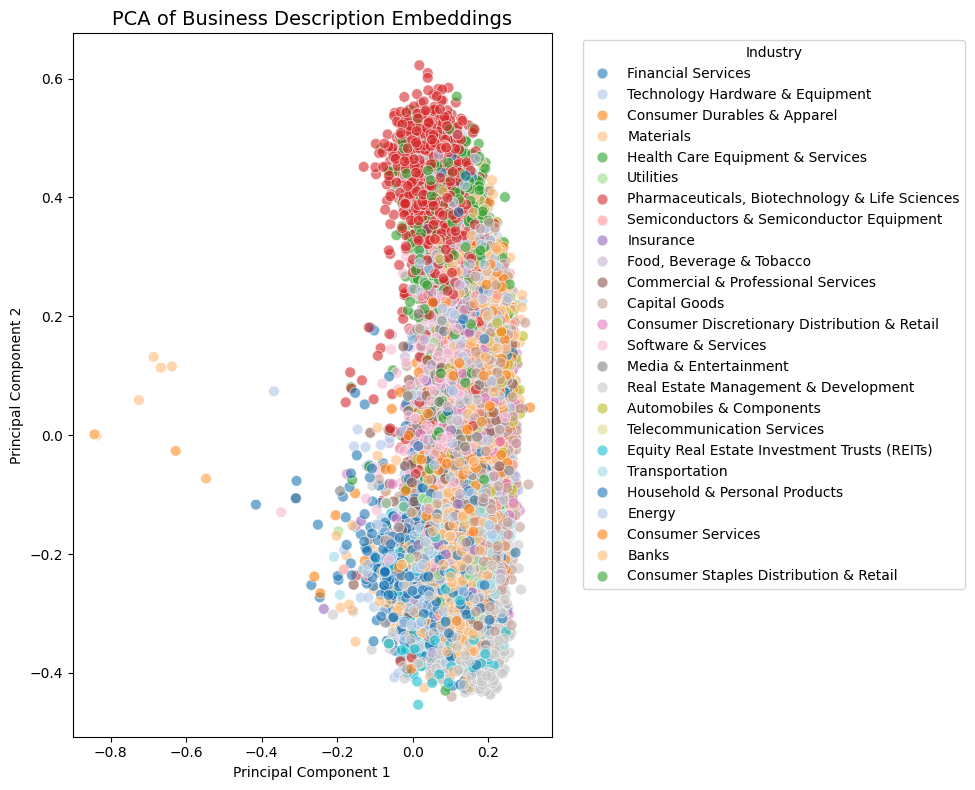

In [75]:
pca = PCA(n_components=2).fit(X_train)
X_train_proj = pca.transform(X_train)

pca_df = pd.DataFrame({
    'PC1': X_train_proj[:, 0],
    'PC2': X_train_proj[:, 1],
    'industry': df_train['industry'].values
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='industry',
    palette='tab20',
    alpha=0.6,
    s=60,
    edgecolor='w' 
)
plt.title("PCA of Business Description Embeddings", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
print(X_train.shape)

(28535, 768)


## <span style='color: green;'>Our Findings</span>
It is difficult to say whether the signal allows for good classification, because the way the 768 dimensions got reduced to 2. However, it seems there is some clustering, so we assume some okay-ish/good classification is possible.



# Fitting and comparing Classifier Models

### Tasks:
- Split the data into train and validation data
- Encode the industry labels using LabelEncoder (scikit-learn)
- Fit a LogisticRegression and a kNN-classifier
- Compare the model performance of both models:
    - Compute Accuracy and F1 score
        - Interpret the scores: Explain how they are computed and judge if your model performs well
        - Analyze the classification errors: 
            - Do the errors correlate with how well classes are represented?
            - Which industries does the model identify well and which seem to be similar?
    - Plot a confusion matrix for both models (combine scikit-learn confusion matrix and seaborn heatmap plot)
    - Do both models misclassify the same examples?

Import: Use proper axis labels for the plots! 

In [148]:
# your code

# Optional: Confidence Weighted Prediction

## Deliverables:

- Provide a notebook with the implementation and training of a industry classifier model
- The model shall output the industry classification and its confidence as a tuple of vectors $(\hat{y}_{pred}, \hat{y}_{confidence})$
- The confidence score must be between 0 and 1, $\hat{y}_{confidence} [i] \in [0,1]$
- Your model will be evaluated on a private test set
- The designing the confidence score is your task. You may use p-values, a voting mechanism of multiple models, or other techniques
- Another option is to add more features, e.g. financial data, to X

In [139]:
def confidence_weighted_f1(y_true, y_pred, confidence):
    # Weight all predictions, not just positives
    weighted_tp = np.sum(confidence * (y_pred == 1) * (y_true == 1))
    weighted_fp = np.sum(confidence * (y_pred == 1) * (y_true == 0))
    weighted_fn = np.sum(confidence * (y_pred == 0) * (y_true == 1))
    
    precision = weighted_tp / (weighted_tp + weighted_fp) if (weighted_tp + weighted_fp) > 0 else 0
    recall = weighted_tp / (weighted_tp + weighted_fn) if (weighted_tp + weighted_fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1